## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Error importing in API mode: ImportError("dlopen(/Users/wongpeiting/.pyenv/versions/3.13.9/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <B96A8100-FA7A-3EFC-8726-931D26646DE6> /Users/wongpeiting/.pyenv/versions/3.13.9/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [5]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [6]:
%%R 

library(sf)
library(tigris)

# TOPIC: Who are the super sloggers in NYC?
# Table B23020: Mean Usual Hours Worked for Workers 16-64 Years
#
# First, let's explore what variables are in this table

b23020_vars <- load_variables(2023, "acs5") %>%
  filter(str_detect(name, "B23020_"))

b23020_vars %>% 
  select(name, label) %>%
  print(n = 20)

# A tibble: 3 × 2
  name       label                                       
  <chr>      <chr>                                       
1 B23020_001 Estimate!!Mean usual hours--!!Total:        
2 B23020_002 Estimate!!Mean usual hours--!!Total:!!Male  
3 B23020_003 Estimate!!Mean usual hours--!!Total:!!Female


Linking to GEOS 3.14.1, GDAL 3.12.2, PROJ 9.7.1; sf_use_s2() is TRUE
To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.


In [7]:
%%R 

# Fetch mean hours worked data at TRACT level
# B23020_001 = Mean hours for ALL workers
# B23020_002 = Mean hours for MALE workers  
# B23020_003 = Mean hours for FEMALE workers

nyc_hours <- get_acs(
  geography = "tract",
  state = "NY",
  county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
  variables = c(
    mean_hours_total = "B23020_001",
    mean_hours_male = "B23020_002",
    mean_hours_female = "B23020_003"
  ),
  year = 2023,
  survey = "acs5",
  geometry = TRUE,
  output = "wide"
)

# Quick look at the data
nyc_hours %>%
  st_drop_geometry() %>%
  select(NAME, mean_hours_totalE, mean_hours_maleE, mean_hours_femaleE) %>%
  head(10)

                                          NAME mean_hours_totalE
1  Census Tract 235.02; Bronx County; New York              34.7
2     Census Tract 135; Bronx County; New York              28.7
3      Census Tract 92; Bronx County; New York              35.8
4      Census Tract 54; Bronx County; New York              34.8
5  Census Tract 365.01; Bronx County; New York              37.6
6  Census Tract 449.02; Bronx County; New York              39.6
7     Census Tract 175; Bronx County; New York              31.4
8     Census Tract 219; Bronx County; New York              33.0
9      Census Tract 74; Bronx County; New York              35.4
10    Census Tract 220; Bronx County; New York              36.5
   mean_hours_maleE mean_hours_femaleE
1              37.0               32.9
2              28.8               28.7
3              37.8               33.9
4              36.2               33.2
5              40.3               33.0
6              40.5               39.0
7           

Getting data from the 2019-2023 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


In [8]:
%%R 

# Data is already wide format, just need to clean up and add borough

nyc_hours <- nyc_hours %>%
  mutate(
    # Safer borough extraction - handle varying NAME formats
    borough = case_when(
      str_detect(NAME, "New York County") ~ "New York County",
      str_detect(NAME, "Kings County") ~ "Kings County",
      str_detect(NAME, "Queens County") ~ "Queens County",
      str_detect(NAME, "Bronx County") ~ "Bronx County",
      str_detect(NAME, "Richmond County") ~ "Richmond County",
      TRUE ~ "Unknown"
    ),
    # Calculate gender gap in hours (male - female)
    hours_gap = mean_hours_maleE - mean_hours_femaleE,
    # Calculate CV for reliability check
    cv = ifelse(mean_hours_totalE > 0, 
                (mean_hours_totalM / mean_hours_totalE) * 100, NA)
  ) %>%
  filter(!is.na(mean_hours_totalE))

# Summary statistics
cat("MEAN HOURS WORKED - Summary:\n")
cat("============================\n\n")
summary(nyc_hours$mean_hours_totalE)

cat("\nBy gender:\n")
cat("Male mean:  ", round(mean(nyc_hours$mean_hours_maleE, na.rm=T), 1), "hours\n")
cat("Female mean:", round(mean(nyc_hours$mean_hours_femaleE, na.rm=T), 1), "hours\n")

cat("\nNumber of tracts:", nrow(nyc_hours))

MEAN HOURS WORKED - Summary:


By gender:
Male mean:   39.5 hours
Female mean: 36.1 hours

Number of tracts: 2222

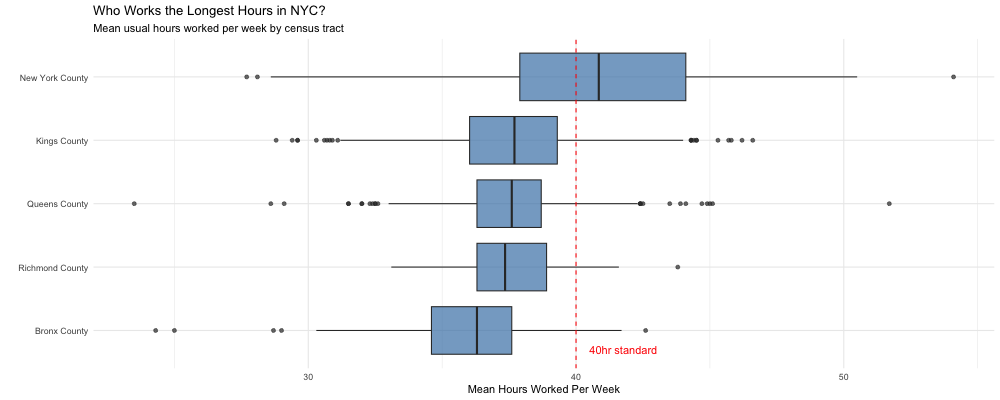

In [9]:
%%R -w 1000 -h 400

# Boxplot: Mean hours worked by borough
ggplot(nyc_hours) +
  aes(x = mean_hours_totalE, y = reorder(borough, mean_hours_totalE, FUN = median)) +
  geom_boxplot(fill = "steelblue", alpha = 0.7) +
  geom_vline(xintercept = 40, linetype = "dashed", color = "red") +
  annotate("text", x = 40.5, y = 0.7, label = "40hr standard", color = "red", hjust = 0) +
  labs(
    title = "Who Works the Longest Hours in NYC?",
    subtitle = "Mean usual hours worked per week by census tract",
    x = "Mean Hours Worked Per Week",
    y = ""
  ) +
  theme_minimal()

In [10]:
%%R -w 1000 -h 400

# Who are the SUPER SLOGGERS? Find the top 10 tracts
top_sloggers <- nyc_hours %>%
  st_drop_geometry() %>%
  arrange(desc(mean_hours_totalE)) %>%
  select(NAME, borough, mean_hours_totalE, mean_hours_maleE, mean_hours_femaleE) %>%
  head(10)

cat("🏆 TOP 10 SUPER SLOGGER NEIGHBORHOODS:\n")
cat("======================================\n")
print(top_sloggers)

🏆 TOP 10 SUPER SLOGGER NEIGHBORHOODS:
                                             NAME         borough
1  Census Tract 112.02; New York County; New York New York County
2       Census Tract 426; Queens County; New York   Queens County
3      Census Tract 58; New York County; New York New York County
4       Census Tract 9; New York County; New York New York County
5      Census Tract 84; New York County; New York New York County
6      Census Tract 33; New York County; New York New York County
7      Census Tract 77; New York County; New York New York County
8     Census Tract 128; New York County; New York New York County
9      Census Tract 79; New York County; New York New York County
10    Census Tract 116; New York County; New York New York County
   mean_hours_totalE mean_hours_maleE mean_hours_femaleE
1               54.1             54.4               53.9
2               51.7             51.7                 NA
3               50.5             55.6               45.1
4       

Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


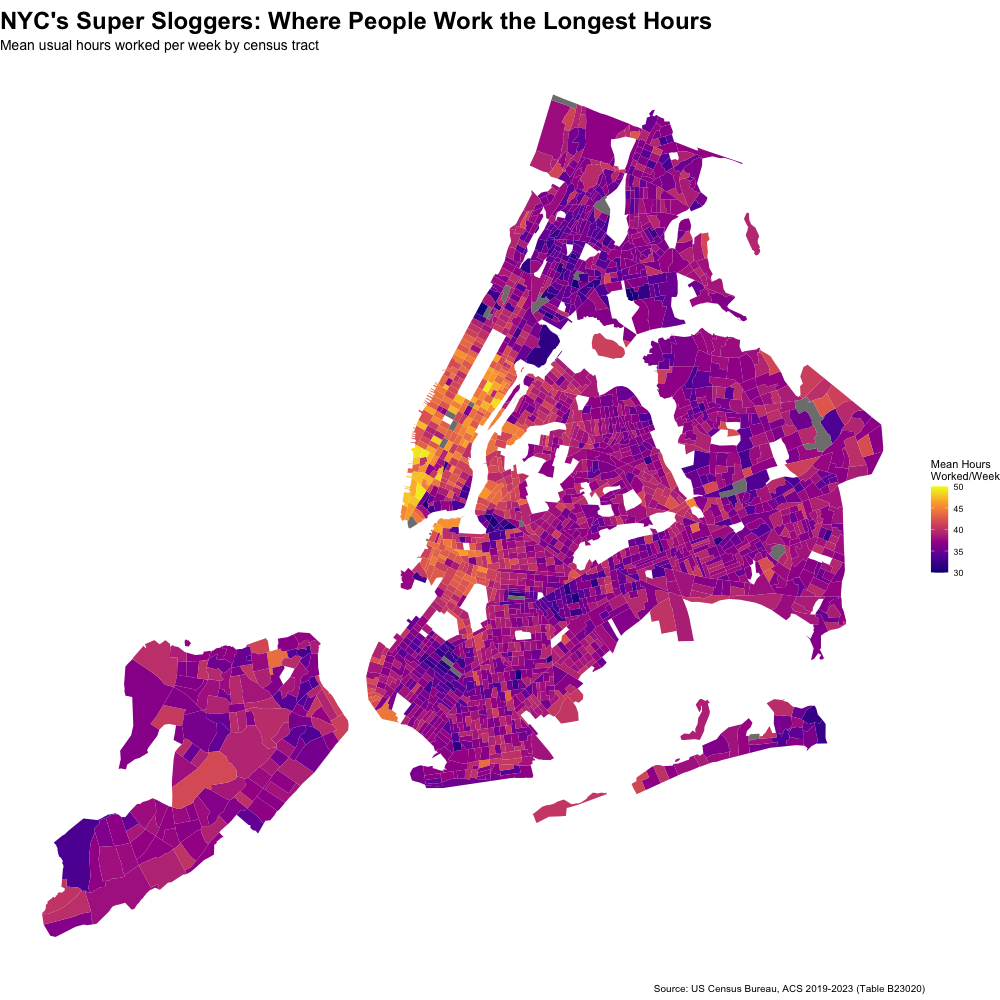

In [11]:
%%R -w 1000 -h 1000

# Map: Where are the super sloggers?
# Try to erase water bodies for cleaner map
nyc_hours_map <- tryCatch(
  nyc_hours %>% erase_water(area_threshold = 0.9),
  error = function(e) nyc_hours  # Fall back to original if erase_water fails
)

ggplot(nyc_hours_map) +
  geom_sf(aes(fill = mean_hours_totalE), color = NA) +
  scale_fill_viridis_c(
    option = "plasma",
    name = "Mean Hours\nWorked/Week",
    limits = c(30, 50)
  ) +
  theme_void() +
  labs(
    title = "NYC's Super Sloggers: Where People Work the Longest Hours",
    subtitle = "Mean usual hours worked per week by census tract",
    caption = "Source: US Census Bureau, ACS 2019-2023 (Table B23020)"
  ) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    plot.subtitle = element_text(size = 14),
    plot.caption = element_text(size = 10)
  )

---

## Gender Gap in Hours Worked

Let's also look at the difference between male and female work hours. A positive gap means men work more hours; negative means women work more.

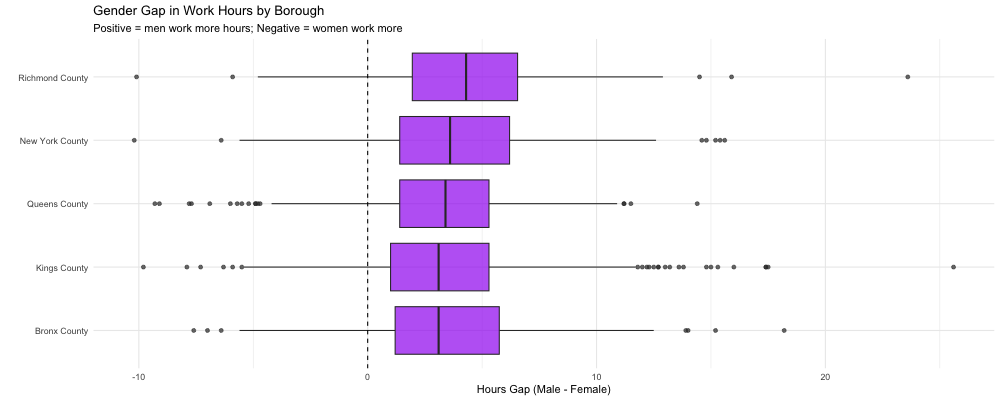

In [12]:
%%R -w 1000 -h 400

# Gender gap by borough
ggplot(nyc_hours %>% filter(!is.na(hours_gap))) +
  aes(x = hours_gap, y = reorder(borough, hours_gap, FUN = median)) +
  geom_boxplot(fill = "purple", alpha = 0.7) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black") +
  labs(
    title = "Gender Gap in Work Hours by Borough",
    subtitle = "Positive = men work more hours; Negative = women work more",
    x = "Hours Gap (Male - Female)",
    y = ""
  ) +
  theme_minimal()

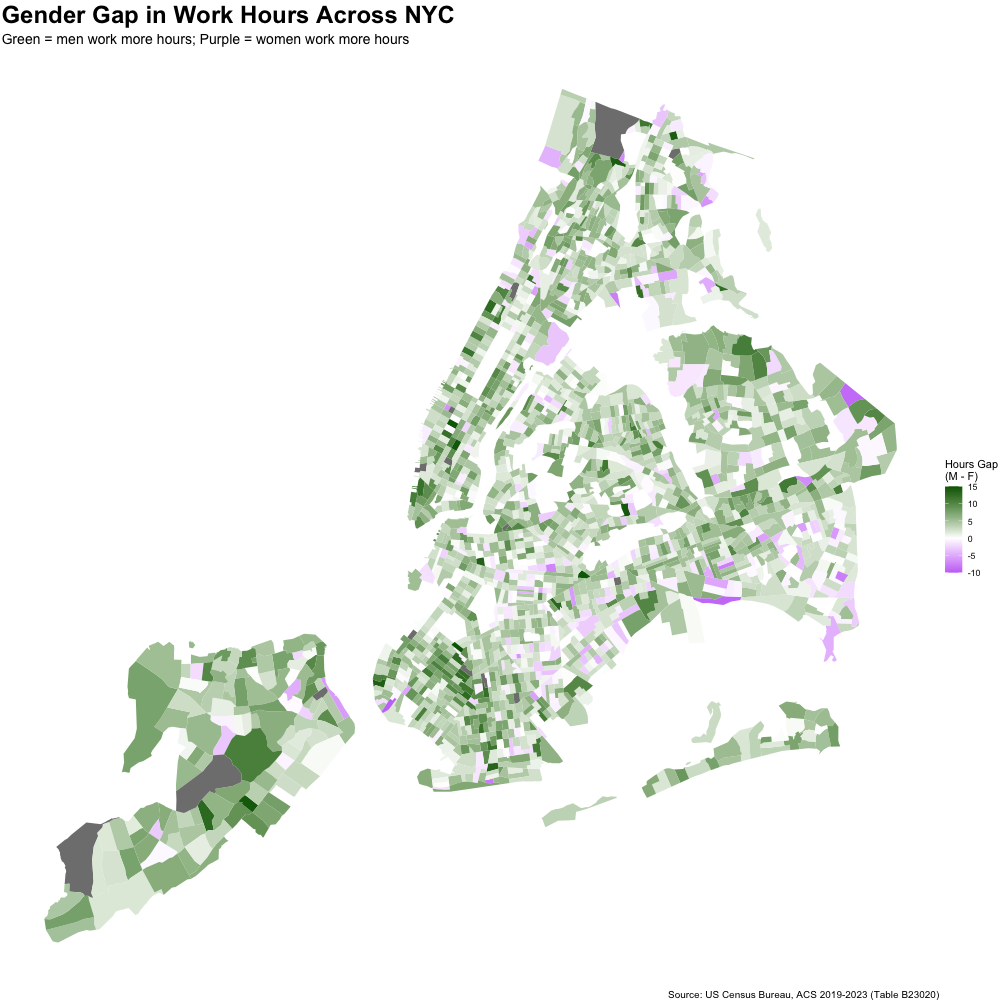

In [13]:
%%R -w 1000 -h 1000

# Map: Gender gap in hours worked
ggplot(nyc_hours_map %>% filter(!is.na(hours_gap))) +
  geom_sf(aes(fill = hours_gap), color = NA) +
  scale_fill_gradient2(
    low = "purple",
    mid = "white",
    high = "darkgreen",
    midpoint = 0,
    name = "Hours Gap\n(M - F)",
    limits = c(-10, 15)
  ) +
  theme_void() +
  labs(
    title = "Gender Gap in Work Hours Across NYC",
    subtitle = "Green = men work more hours; Purple = women work more hours",
    caption = "Source: US Census Bureau, ACS 2019-2023 (Table B23020)"
  ) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    plot.subtitle = element_text(size = 14),
    plot.caption = element_text(size = 10)
  )

---

## 📝 Key Findings

Run all the cells above to discover:

1. **Which neighborhoods have the longest work hours?** (Top 10 super sloggers)
2. **How do boroughs compare?** (Boxplot)
3. **Where are the super sloggers on the map?** (Choropleth)
4. **What's the gender gap in work hours?** (Male vs Female comparison)

### Data Quality Note

Unlike the birth data we analyzed earlier, **hours worked data is much more reliable** because:
- It's based on a larger population (all workers 16-64, not just women who gave birth)
- The estimates have lower margins of error
- Most tracts should have CV < 10%

---

## 📝 Key Takeaways: NYC's Super Sloggers

### What we found:

1. **Mean hours worked varies by neighborhood** - some census tracts average well above 40 hours/week
2. **Borough patterns** - Manhattan tends to have higher mean hours (finance, consulting, tech)
3. **Gender gap exists everywhere** - men work more hours on average in every borough
4. **Data quality is good** - unlike rare events (births), hours worked data is reliable at tract level

### Questions to explore further:

- Do high-hours neighborhoods correlate with high-income neighborhoods?
- Where is the gender gap largest? (Look for dark green on the gender gap map)
- Are there neighborhoods where women work MORE hours than men? (Purple areas)

---

*Table B23020: Mean Usual Hours Worked in the Past 12 Months for Workers 16 to 64 Years*

---

## Pre-COVID vs Post-COVID: How Work Hours Changed

Comparing ACS 2015-2019 (pre-COVID) with ACS 2019-2023 (post-COVID) data.

In [ ]:
%%R

# Fetch PRE-COVID data (2015-2019 ACS 5-year)
nyc_hours_precovid <- get_acs(
  geography = "tract",
  state = "NY",
  county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
  variables = c(
    mean_hours_total = "B23020_001",
    mean_hours_male = "B23020_002",
    mean_hours_female = "B23020_003"
  ),
  year = 2019,
  survey = "acs5",
  geometry = TRUE,
  output = "wide"
) %>%
  filter(!is.na(mean_hours_totalE))

# Erase water
nyc_hours_precovid_map <- tryCatch(
  nyc_hours_precovid %>% erase_water(area_threshold = 0.9),
  error = function(e) nyc_hours_precovid
)

cat("Pre-COVID tracts:", nrow(nyc_hours_precovid))

In [ ]:
%%R -w 1000 -h 1000

# PRE-COVID MAP (2015-2019)
ggplot(nyc_hours_precovid_map) +
  geom_sf(aes(fill = mean_hours_totalE), color = NA) +
  scale_fill_viridis_c(
    option = "plasma",
    name = "Mean Hours\nWorked/Week",
    limits = c(30, 50)
  ) +
  theme_void() +
  labs(
    title = "PRE-COVID: Mean Hours Worked (2015-2019)",
    subtitle = "Before the pandemic changed work patterns",
    caption = "Source: US Census Bureau, ACS 2015-2019 (Table B23020)"
  ) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    plot.subtitle = element_text(size = 14),
    plot.caption = element_text(size = 10)
  )

In [ ]:
%%R -w 1000 -h 1000

# POST-COVID MAP (2019-2023)
ggplot(nyc_hours_map) +
  geom_sf(aes(fill = mean_hours_totalE), color = NA) +
  scale_fill_viridis_c(
    option = "plasma",
    name = "Mean Hours\nWorked/Week",
    limits = c(30, 50)
  ) +
  theme_void() +
  labs(
    title = "POST-COVID: Mean Hours Worked (2019-2023)",
    subtitle = "After remote work and pandemic shifts",
    caption = "Source: US Census Bureau, ACS 2019-2023 (Table B23020)"
  ) +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    plot.subtitle = element_text(size = 14),
    plot.caption = element_text(size = 10)
  )